# Gaussian Mixture Models 
GMM (Gaussian Mixture Model) is a probabilistic unsupervised machine learning algorithm used for clustering and density estimation. It assumes that the data is generated from a mixture of Gaussian distributions, where each distribution represents a cluster. GMM estimates the parameters of these Gaussian distributions to model the data and assigns each data point to the most likely cluster based on the probability distribution. It allows for more flexible and complex cluster shapes compared to other clustering algorithms, as it considers the covariance between variables and allows data points to belong to multiple clusters with different probabilities.


### Import libraries and initialize random generator

In [193]:
import numpy as np
import pandas as pd 
from sklearn.cluster import KMeans

### Read data from CSV
we will (again) use the wholesale customers dataset. The data set includes the annual spending amount on 6 product categories of 440 customers. We will try to group these customers into different clusters, which in real life may represent groups such as individual buyers, business owners, tourists ... (these are just examples. GMM does not give any labels)

In [194]:
dataset = pd.read_csv("https://raw.githubusercontent.com/TrainingByPackt/Data-Science-with-Python/master/Chapter01/Data/Wholesale%20customers%20data.csv")
display(dataset)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


`Channel` and `Region` are categorical variables, so these feature are not suitable for GMM. We will therefore remove them

In [195]:
dataset = dataset.drop(['Channel', 'Region'], axis=1)

### Standardizing dataset values 
GMM is sensitive to the scales of the features, and features with larger scales can dominate the clustering algorithm. By standardizing the dataset, we transform the features to have a mean of 0 and a standard deviation of 1, which brings all features to a similar scale (i.e. using z-scores instead of raw values). This allows the model to treat all features equally and prevent any single feature from dominating the clustering process based on its scale.

In [196]:
def standardize_data(dataset):
    mean = np.mean(dataset, axis=0)  # Calculate the mean along the columns
    std = np.std(dataset, axis=0)    # Calculate the standard deviation along the columns
    data_scaled = (dataset - mean) / std  # Standardize the dataset
    return data_scaled

X = standardize_data(dataset)
display(X)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339
1,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151
2,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293
3,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411
4,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347
...,...,...,...,...,...,...
435,1.401312,0.848446,0.850760,2.075222,-0.566831,0.241091
436,2.155293,-0.592142,-0.757165,0.296561,-0.585519,0.291501
437,0.200326,1.314671,2.348386,-0.543380,2.511218,0.121456
438,-0.135384,-0.517536,-0.602514,-0.419441,-0.569770,0.213046


convert the dataset X from pandas table into a numpy 2d matrix, so we can perform matrix multiplications later

In [197]:
X = X.to_numpy()
print(X)

[[ 0.05293319  0.52356777 -0.04111489 -0.58936716 -0.04356873 -0.06633906]
 [-0.39130197  0.54445767  0.17031835 -0.27013618  0.08640684  0.08915105]
 [-0.44702926  0.40853771 -0.0281571  -0.13753572  0.13323164  2.24329255]
 ...
 [ 0.20032554  1.31467078  2.34838631 -0.54337975  2.51121768  0.12145607]
 [-0.13538389 -0.51753572 -0.60251388 -0.41944059 -0.56977032  0.21304614]
 [-0.72930698 -0.5559243  -0.57322717 -0.62009417 -0.50488752 -0.52286938]]


### Gaussian density
In GMM, we assume all variables are normally distributed. This allows us to calculate the probability of a value coming from the distributions.

\begin{equation}
\large
p(\mathbf x | \mathbf\mu, \mathbf\Sigma) = \frac 1 {({2\pi})^{n/2}|\Sigma|^{1/2}}\exp\left(-\frac 1 2 (\mathbf x -\mathbf\mu)^T\mathbf\Sigma^{-1}(\mathbf x -\mathbf\mu)\right)
\end{equation}

note that the $\Sigma$ here does NOT mean summation. It is the symbol for the covariance matrix


In [198]:
def gaussian_probability_density(X, mean, covariance):
    num_dimensions = X.shape[1]
    difference = (X - mean).T
    
    exponent = -0.5 * np.dot(np.dot(difference.T, np.linalg.inv(covariance)), difference)
    coefficient = 1 / ((2 * np.pi) ** (num_dimensions / 2) * np.linalg.det(covariance) ** 0.5)
    
    probability = np.diagonal(coefficient * np.exp(exponent))
    
    #convert row matrix to column
    probability_column = probability.reshape(-1, 1)
    
    return probability_column

# Gaussian mixture models with Expectation-Maximization algorithm
Assuming there are K clusters, a Gaussian Mixture is a function made up of K Gaussians, each labeled with a number $k$ (ranging from 1 to K), representing the clusters in our dataset. Each Gaussian $k$ in the mixture is have three parameters

- A mean $μ$ that defines its centre.
- A covariance matrix $Σ$ that defines its width. This would be equivalent to the dimensions of an ellipsoid in a multivariate scenario.
- A mixing probability $π$ that defines how big or small the Gaussian function will be. It is also known as the mixing coefficient or weight. The sum of every $π$ should be 1 because the combined probability has to be 100%.
<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*lTv7e4Cdlp738X_WFZyZHA.png">

The EM algorithm is an iterative optimization technique that aims to estimate the parameters of the GMM based on the observed data.
1. Initialization: we start by initializing the parameters of the GMM. This includes the number of mixture components (K), the means (μ), covariances (Σ), and the mixing coefficients (π) of each component. These parameters can be initialized randomly or using some prior knowledge about the data.
2. Expectation (E-step): In this step, the algorithm computes the "responsibilities" of each component for each data point. The responsibility represents the probability of a data point belonging to a specific component given the current parameter estimates. This is calculated using Bayes' rule and involves estimating the probabilities of the data points belonging to each component.
3. Maximization (M-step): In this step, the algorithm updates the parameters of the GMM based on the computed responsibilities. The parameters are updated by maximizing the expected complete-data log-likelihood. The means, covariances, and mixing coefficients are updated using weighted maximum likelihood estimation, where the weights are the responsibilities computed in the E-step.


### Parameter initialization
This is the initialization step of the GMM. At this point, we must initialise our parameters $\pi_k$, $\mu_k$, and $\Sigma_k$. We are going to use a random point for $\mu_k$, set $\pi_k$ to one over the number of clusters and $\Sigma_k$ to the identity matrix. 

Note: 
GMMs do not inherently determine the number of clusters in the data. The number of clusters is typically determined by the user based on existing knowledge or by using a separate technique such as the elbow method. We will choose 3 as an arbitrary choice for the number of clusters.


In [199]:
n_clusters=3
clusters = []
idx = np.arange(X.shape[0])

random_indices = np.random.choice(X.shape[0], size=n_clusters, replace=False)
mu_k = X[random_indices]
print(mu_k)

[[-0.1854118  -0.49027034 -0.63654126  0.5293848  -0.55990142 -0.42666431]
 [ 1.47421656  0.19163549 -0.32176171  3.22511303 -0.44483419  0.47965132]
 [-0.18984465 -0.60774209 -0.70459601 -0.03112539 -0.42845601 -0.43837932]]


In [200]:
for i in range(n_clusters):
    clusters.append({
        'pi_k': 1.0 / n_clusters,
        'mu_k': mu_k[i],
        'cov_k': np.identity(X.shape[1], dtype=np.float64)
    })

for dictionary in clusters:
    print("\n")
    for entrys in dictionary.items():
        print(entrys)



('pi_k', 0.3333333333333333)
('mu_k', array([-0.1854118 , -0.49027034, -0.63654126,  0.5293848 , -0.55990142,
       -0.42666431]))
('cov_k', array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]))


('pi_k', 0.3333333333333333)
('mu_k', array([ 1.47421656,  0.19163549, -0.32176171,  3.22511303, -0.44483419,
        0.47965132]))
('cov_k', array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]))


('pi_k', 0.3333333333333333)
('mu_k', array([-0.18984465, -0.60774209, -0.70459601, -0.03112539, -0.42845601,
       -0.43837932]))
('cov_k', array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
   

### Expectation function
This function finds the probabilities of each data point belonging to each component of the mixture model. In this step, the quantity $\gamma(z_{nk})$ represents the responsibility of the k-th component for the n-th data point.

\begin{equation}
\large
\gamma{(z_{nk})}=\frac {\pi_k\mathcal N(\mathbf x_n| \mathbf\mu_k, \mathbf\Sigma_k)}{\sum_{j=1}^K\pi_j\mathcal N(\mathbf x_n| \mathbf\mu_j, \mathbf\Sigma_j)}
\end{equation}

For convenience, we just calculate the denominator as a sum over all terms in the numerator, and then assign it to a variable named `totals`. This variable will be used later

In [201]:
def expectation(X, clusters):
    global gamma_nk, totals
    N = X.shape[0]
    K = len(clusters)
    totals = np.zeros((N, 1), dtype=np.float64)
    gamma_nk = np.zeros((N, K), dtype=np.float64)
    
    for k, kth_cluster in enumerate(clusters):
        pi_k = kth_cluster['pi_k']
        mu_k = kth_cluster['mu_k']
        cov_k = kth_cluster['cov_k']
    
        gamma_nk[:, k] = (pi_k * gaussian_probability_density(X, mu_k, cov_k)).flatten()
    
    totals = np.sum(gamma_nk, 1)
    gamma_nk /= np.expand_dims(totals, 1)

### Maximization function

Now we will implement the maximization step. This is where we changes the $\pi_k$, $\mu_k$ and $\Sigma_k$ to iteratively make the model better.

Since $\gamma(z_{nk})$ is common to the expressions for $\pi_k$, $\mu_k$ and $\Sigma_k$, we can simply define:

\begin{equation}
\large
N_k=\sum_{n=1}^N\gamma({z_{nk}})
\end{equation}

And then we can calculate the revised parameters by using:

\begin{equation}
\large
\pi_k^*=\frac {N_k} N
\end{equation}


\begin{equation}
\large
\mu_k^*=\frac 1 {N_k} \sum_{n=1}^N\gamma({z_{nk}})\mathbf x_n
\end{equation}


\begin{equation}
\large
\Sigma_k^*=\frac 1 {N_k} \sum_{n=1}^N\gamma({z_{nk}})(\mathbf x_n-\mathbf\mu_k)(\mathbf x_n-\mathbf\mu_k)^T
\end{equation}

Note: To calculate the covariance, we define an auxiliary variable __diff__ that contains $(x_n-\mu_k)^T$.

In [202]:
def maximize(X, clusters):
    global gamma_nk
    N = float(X.shape[0])
  
    for k, kth_cluster in enumerate(clusters):
        gamma_k = np.expand_dims(gamma_nk[:, k], 1)
        N_k = np.sum(gamma_k, axis=0)
        
        pi_k = N_k / N
        mu_k = np.sum(gamma_k * X, axis=0) / N_k
        cov_k = (gamma_k * (X - mu_k)).T @ (X - mu_k) / N_k
        
        kth_cluster['pi_k'] = pi_k
        kth_cluster['mu_k'] = mu_k
        kth_cluster['cov_k'] = cov_k

### Log-likelihood

The log-likelihood of a GMM is a measure of how well the model fits the given data. It quantifies the probability of the observed data points under the GMM. The log-likelihood is given by the sum of the logarithm of the probabilities of each data point, calculated using the GMM.

The equation is:

\begin{equation}
\large
\ln p(\mathbf X)=\sum_{n=1}^N\ln\sum_{k=1}^K\pi_k\mathcal N(\mathbf x_n|\mu_k,\Sigma_k)
\end{equation}

Note: the second summation has already been calculated in the `expectation` function and is available in the __totals__ variable. So we just make use of it.

In [203]:
def log_likelihood(X, clusters):
    global gamma_nk, totals
    sample_likelihoods = np.log(totals)
    return np.sum(sample_likelihoods)

Finally, let's put everything together! First, we are going to initialise the parameters by using the `initialise_clusters` function, and then perform several expectation-maximization steps. In this case, we set the number of iterations of the training procedure to a fixed `n_epochs` number. I have done this on purpose to generate graphs of the log-likelihood later.

In [204]:
n_epochs = 50
likelihoods = np.zeros((n_epochs, ))
scores = np.zeros((X.shape[0], n_clusters))
history = []

for i in range(n_epochs):

    # Not necessary. This is just for our later use in the graphs
    clusters_snapshot = []
    for cluster in clusters:
        clusters_snapshot.append({
            'mu_k': cluster['mu_k'].copy(),
            'cov_k': cluster['cov_k'].copy()
        })
    history.append(clusters_snapshot)

    
    # apply the EM algorithm
    expectation(X, clusters)
    maximize(X, clusters)
    
    
    # Not necessary. This is just for monitoring the progress of training
    likelihood = log_likelihood(X, clusters)
    likelihoods[i] = likelihood
    print('Epoch: ', i + 1, 'Likelihood: ', likelihood)

scores = np.log(gamma_nk)

Epoch:  1 Likelihood:  -4036.7603753706812
Epoch:  2 Likelihood:  -2237.227247918636
Epoch:  3 Likelihood:  -2012.9687765044744
Epoch:  4 Likelihood:  -1844.9057151774314
Epoch:  5 Likelihood:  -1746.216082094005
Epoch:  6 Likelihood:  -1707.5719532382852
Epoch:  7 Likelihood:  -1681.2976225885704
Epoch:  8 Likelihood:  -1648.0184918009518
Epoch:  9 Likelihood:  -1608.7214805018552
Epoch:  10 Likelihood:  -1577.6159263092197


/tmp/ipykernel_32/3018580005.py:8: RuntimeWarning: overflow encountered in exp
  probability = np.diagonal(coefficient * np.exp(exponent))


Epoch:  11 Likelihood:  -1559.898791193053
Epoch:  12 Likelihood:  -1552.1367145277554
Epoch:  13 Likelihood:  -1546.654016879777
Epoch:  14 Likelihood:  -1540.9169026341951
Epoch:  15 Likelihood:  -1535.9578004331197
Epoch:  16 Likelihood:  -1532.4148425717212
Epoch:  17 Likelihood:  -1530.8787533116392
Epoch:  18 Likelihood:  -1530.242578687038
Epoch:  19 Likelihood:  -1529.8285999303425
Epoch:  20 Likelihood:  -1529.5193986787656
Epoch:  21 Likelihood:  -1529.3342956147644
Epoch:  22 Likelihood:  -1529.2543727694779
Epoch:  23 Likelihood:  -1529.2279788796727
Epoch:  24 Likelihood:  -1529.2204249369074
Epoch:  25 Likelihood:  -1529.2183385528756
Epoch:  26 Likelihood:  -1529.217746008444
Epoch:  27 Likelihood:  -1529.2175681282292
Epoch:  28 Likelihood:  -1529.217511352767
Epoch:  29 Likelihood:  -1529.2174921851981
Epoch:  30 Likelihood:  -1529.2174854054806
Epoch:  31 Likelihood:  -1529.2174829181731
Epoch:  32 Likelihood:  -1529.2174819799493
Epoch:  33 Likelihood:  -1529.2174816

/tmp/ipykernel_32/1534805943.py:28: RuntimeWarning: divide by zero encountered in log
  scores = np.log(gamma_nk)


In [205]:
print(scores)

[[-3.08100457e+01 -9.06315315e+00 -1.15863797e-04]
 [-4.80528881e+01 -9.68550796e+00 -6.21800175e-05]
 [-1.13157211e+02 -1.41873030e-03 -6.55870224e+00]
 ...
 [           -inf -3.11854605e+00 -4.52290009e-02]
 [-2.05444630e-01 -1.16029450e+01 -1.68359222e+00]
 [-1.39042490e-02 -1.34815251e+01 -4.28260601e+00]]


In [206]:
for dictionary in clusters:
    print("\n")
    for entrys in dictionary.items():
        print(entrys)



('pi_k', array([0.46602269]))
('mu_k', array([ 0.09885869, -0.50234629, -0.56494479,  0.11188505, -0.52364981,
       -0.21465726]))
('cov_k', array([[0.81783482, 0.03107459, 0.02071409, 0.12214808, 0.00798051,
        0.08353573],
       [0.03107459, 0.04265974, 0.01694373, 0.05471602, 0.00589017,
        0.01967979],
       [0.02071409, 0.01694373, 0.02816437, 0.03417844, 0.00452378,
        0.01338844],
       [0.12214808, 0.05471602, 0.03417844, 0.52408101, 0.01062246,
        0.07531403],
       [0.00798051, 0.00589017, 0.00452378, 0.01062246, 0.00419375,
        0.00174293],
       [0.08353573, 0.01967979, 0.01338844, 0.07531403, 0.00174293,
        0.06719028]]))


('pi_k', array([0.09815376]))
('mu_k', array([0.78213693, 1.70665585, 1.43599743, 1.12010582, 1.16918397,
       1.28201266]))
('cov_k', array([[ 3.41061564,  0.104381  , -0.40202962,  1.42836678, -0.7790525 ,
         0.84493248],
       [ 0.104381  ,  4.52032533,  2.28057802, -0.4237056 ,  2.25784819,
         1.3

### Visualization
Now we create a graph to visualize our clusters as well as the parameters for the Gaussian mixture. Essentially, what we do here is to create ellipses of different scales in order to map to the coordinates of each Gaussian.

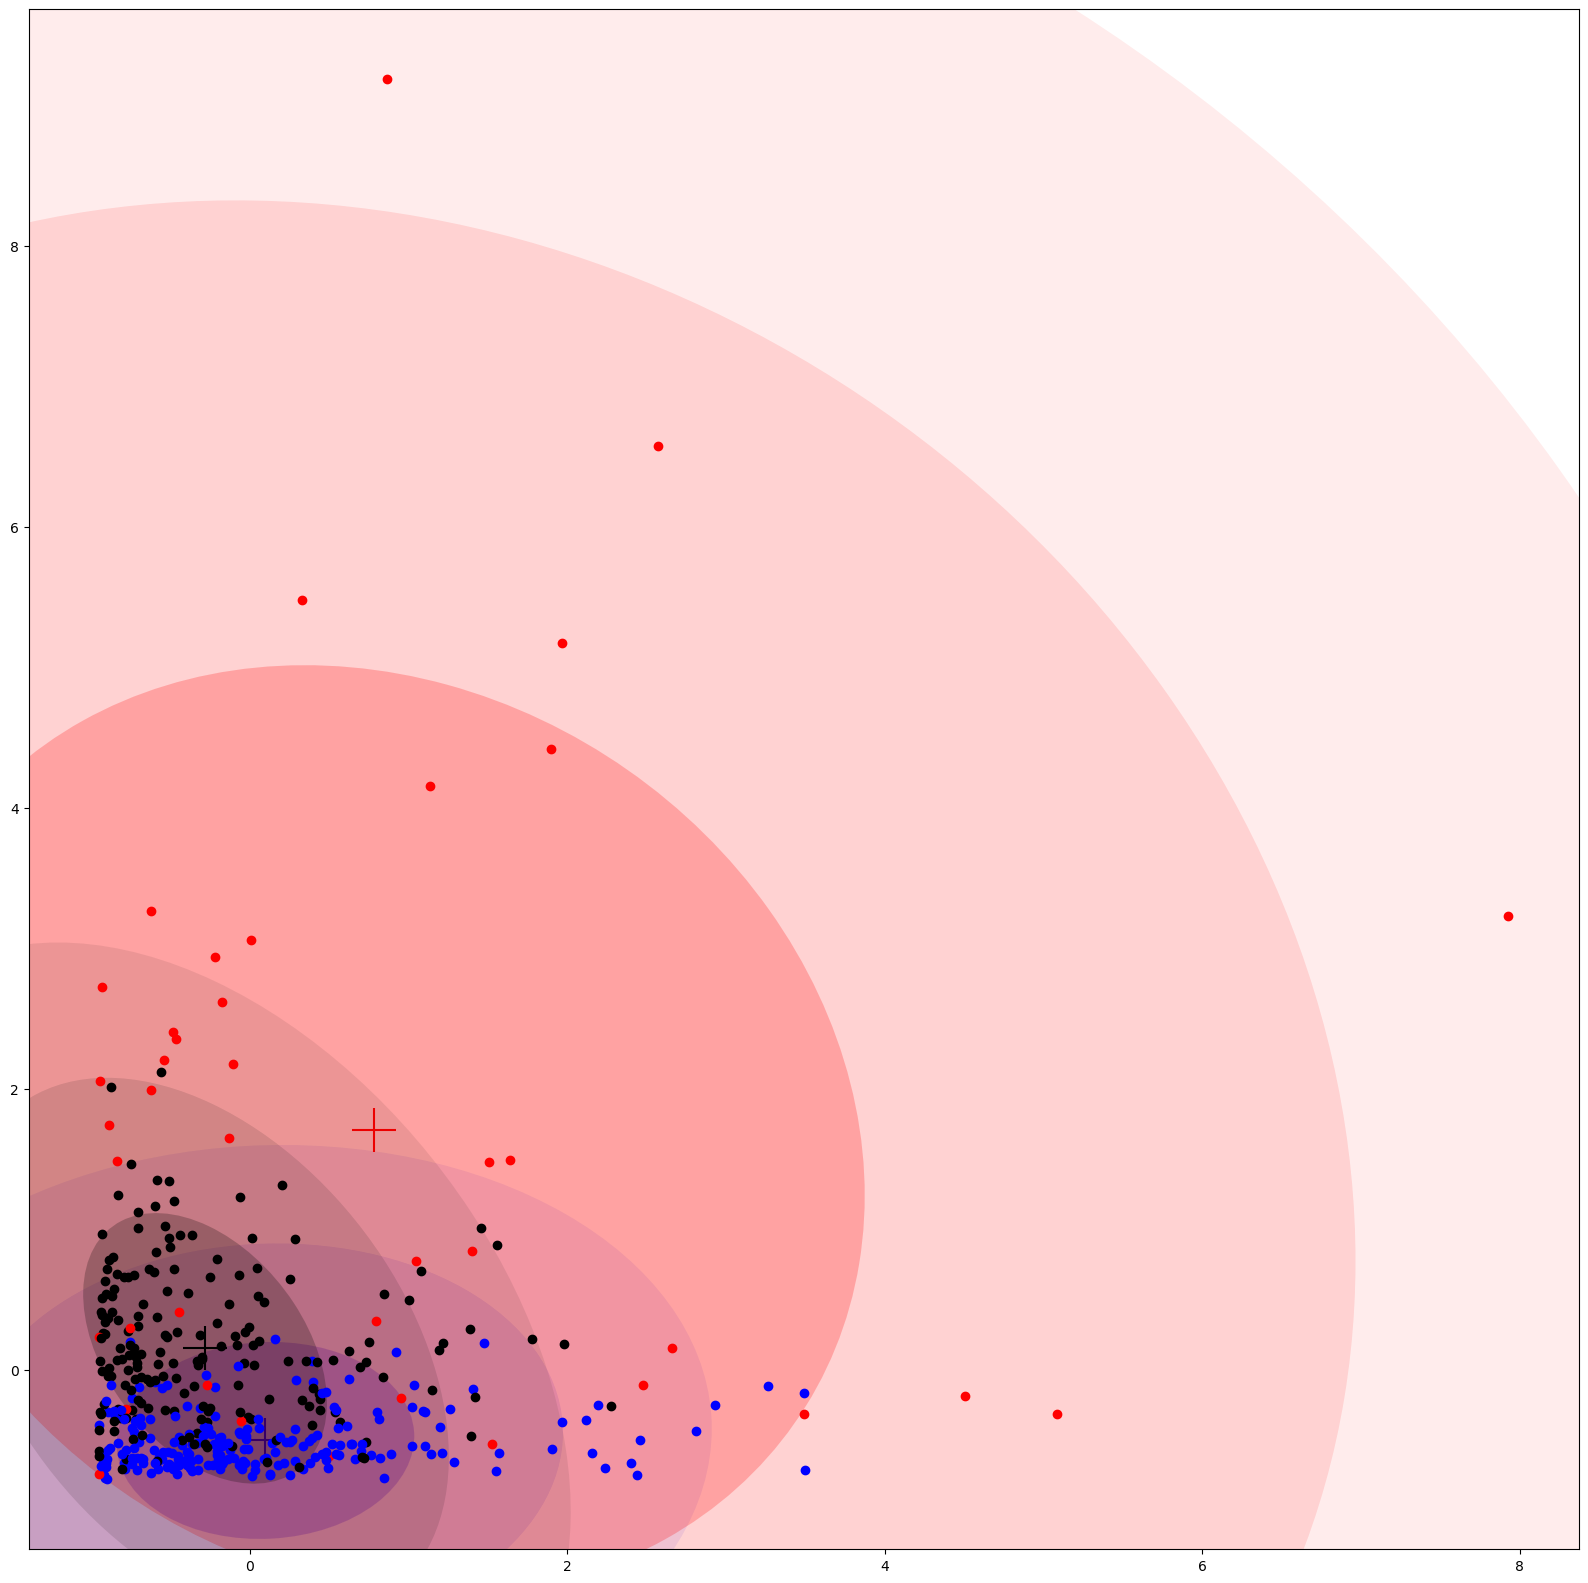

In [208]:
def create_cluster_image(X, history, scores):
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    colorset = ['blue', 'red', 'black']
    
    clusters = history[-1]  # Get the final cluster configuration
    
    k=0
    # drawing ellipses and their centre
    for kth_cluster in clusters:
        mu = kth_cluster['mu_k']
        cov = kth_cluster['cov_k']
        
        #calculate locations of ellipses
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        vx, vy = eigenvectors[:, 0][0], eigenvectors[:, 0][1]
        theta = np.arctan2(vy, vx)

        color = colors.to_rgba(colorset[k])

        for cov_factor in range(1, 4):
            ell = Ellipse(xy=mu, width=np.sqrt(eigenvalues[0]) * cov_factor * 2, height=np.sqrt(eigenvalues[1]) * cov_factor * 2, angle=np.degrees(theta), linewidth=2)
            ell.set_facecolor((color[0], color[1], color[2], 1.0 / (cov_factor * 4.5)))
            ax.add_artist(ell)
        
        # draw the centre
        ax.scatter(kth_cluster['mu_k'][0], kth_cluster['mu_k'][1], c=colorset[k], s=1000, marker='+')
        k += 1
        
    # plot the points from dataset
    for i in range(X.shape[0]):
        ax.scatter(X[i, 0], X[i, 1], c=colorset[np.argmax(scores[i])], marker='o')

    plt.show()
create_cluster_image(X, history, scores)

### Exercise

1. How many numbers are there in the trained model parameter? (hint: we have 6 input variables, 1 output variable, 440 data samples, and 3 classes)
2. Determine the class of this following customer: `[13265, 1196, 4221,6404,507,1788]`
3. In the above implementation of EM algorithm, we are running the loop 50 times. Each iteration costs us time and extra computations. We don’t need to complete all the iterations. We can terminate the loop when the log-likelihood converges (i.e. stopped increasing). Implement this in the code
4. The optimal value for the number of clusters, K, can be determined using the Elbow method. The Elbow method aims to minimize the log-likelihoods. Choosing too few clusters results in high log-likelihoods, while selecting too many clusters makes the model hard to use. Therefore, the Elbow method helps find the appropriate K by identifying the point on the plot where adding more clusters does not significantly increases log-likelihoods anymore.



### References
- https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95